In [2]:
%pylab inline

%load_ext autoreload
%autoreload 2

import pandas as pd
idx = pd.IndexSlice

from scipy.optimize import curve_fit
from scipy import optimize as opt

from inorg_b import phreeqpy_fns as pf
from inorg_b import load
from inorg_b.helpers import d11_2_A11, A11_2_d11, err, extract_model_vars
from inorg_b.model import fitfn, predfn
from inorg_b.plots import model_vs_data

# from otools.plotting import rangecalc

plt.rcParams['figure.dpi'] = 120

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['load']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
# load data
rd = load.processed()

In [4]:
cdict = {'Noireaux': 'C0',
         'Uchikawa': 'C1'}

## Omega - 1 Plot

/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


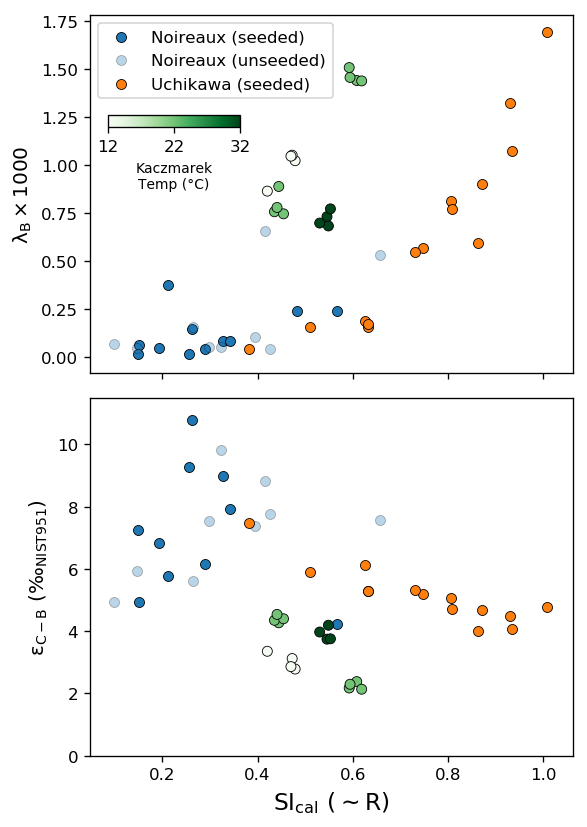

In [5]:
fig, axs = plt.subplots(2, 1, figsize=[5,7], sharex=True)

phase = 'Calcite'

cax, iax = axs

for exp in ['Noireaux', 'Uchikawa']:
    
    slc = idx[:, exp, phase]
    ind = rd.loc[slc, ('Solid', 'seeds')]
    cax.scatter(rd.loc[slc, ('pitzer', 'SIc')][ind],
                rd.loc[slc, ('Solid', 'LambdaB')][ind], label=exp + ' (seeded)',
                lw=0.5, edgecolor='k', c=cdict[exp])
    
    iax.scatter(rd.loc[slc, ('pitzer', 'SIc')][ind],
                rd.loc[slc, ('Solid', 'EpsilonB')][ind], label=exp + ' (seeded)',
                lw=0.5, edgecolor='k', c=cdict[exp])
    
    if any(~ind):
        cax.scatter(rd.loc[slc, ('pitzer', 'SIc')][~ind],
                rd.loc[slc, ('Solid', 'LambdaB')][~ind], label=exp + ' (unseeded)',
                lw=0.5, edgecolor='k', alpha=0.3, c=cdict[exp])
    
        iax.scatter(rd.loc[slc, ('pitzer', 'SIc')][~ind],
                    rd.loc[slc, ('Solid', 'EpsilonB')][~ind], label=exp + ' (unseeded)',
                    lw=0.5, edgecolor='k', alpha=0.3, c=cdict[exp])


exp = 'Kaczmarek'
slc = idx[:, exp, phase]
cm = cax.scatter(rd.loc[slc, ('pitzer', 'SIc')].values,
                 rd.loc[slc, ('Solid', 'LambdaB')].values,
                 c=rd.loc[slc, ('Solution', 'Temp (°C)')], cmap=plt.cm.Greens,
                 lw=0.5, edgecolor='k')

iax.scatter(rd.loc[slc, ('pitzer', 'SIc')],
            rd.loc[slc, ('Solid', 'EpsilonB')],
            c=rd.loc[slc, ('Solution', 'Temp (°C)')], cmap=plt.cm.Greens,
            lw=0.5, edgecolor='k')

cmx = fig.add_axes([.19,.84,.22,.015])
cb = plt.colorbar(cm, cax=cmx, label='Kaczmarek\nTemp (°C)', orientation='horizontal')
cb.set_ticks(rd.loc[slc, ('Solution', 'Temp (°C)')].unique())

cax.legend()
cax.set_ylabel('$\lambda_B \\times 1000$', fontsize=12)
iax.set_ylabel('$\epsilon_{C-B}\ (\u2030_{NIST951})$', fontsize=12)

iax.set_ylim(0,11.5)

iax.set_xlabel('$SI_{cal}\ (\sim R)$', fontsize=14)
fig.tight_layout()

fig.savefig('../../Figures/Fig6-SI-plot.pdf')

Noireax / Mav: Seeded vs unseeded?

## Omega - 1 vs. Precip Rate

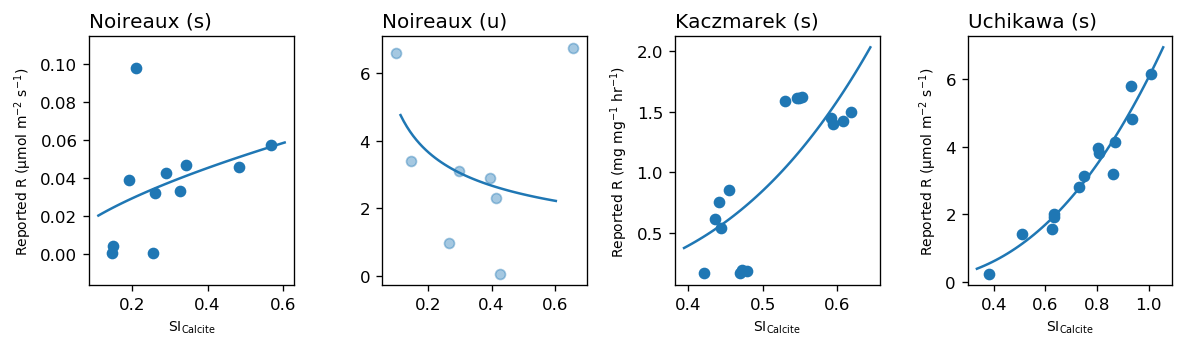

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3))

phase = 'Calcite'

def Rfn(SI, k, n):
    """R as a function of SI"""
    return k * SI**n

rd.dropna(inplace=True, subset=[('Solid', 'logR')])

mu = {'Noireaux': (1e6, '$\mu mol\ m^{-2}\ s^{-1}$'),
      'Kaczmarek': (1, '$mg\ mg^{-1}\ hr^{-1}$'),
      'Uchikawa': (1e6, '$\mu mol\ m^{-2}\ s^{-1}$')}

for exp, ax in zip(['Noireaux', 'Kaczmarek', 'Uchikawa'], axs[[0,2,3]]):
    slc = idx[:, exp, phase]
    ind = rd.loc[slc, ('Solid', 'seeds')]
    
    m, u = mu[exp]

    x = rd.loc[slc, ('pitzer', 'SIc')].astype(float).values
    y = 10**rd.loc[slc, ('Solid', 'logR')].astype(float).values * m
    
    ax.scatter(x[ind], y[ind], c='C0', label='Seeded')
    
    if any(~ind):
        axs[1].scatter(x[~ind], y[~ind], c='C0', alpha=0.4, label='Unseeded')
        p, cov = curve_fit(Rfn, x[~ind], y[~ind])
        SIn = np.linspace(*ax.get_xlim())
        axs[1].plot(SIn, Rfn(SIn, *p))
        axs[1].set_title(exp + ' (u)', loc='left')
        
#     ax.set_ylim(rangecalc(y))
    ax.set_xlabel('$SI_{Calcite}$')
    ax.set_ylabel('Reported R (' + u + ')')
    ax.set_title(exp + ' (s)', loc='left')
    
    # fit line
    p, cov = curve_fit(Rfn, x[ind], y[ind])
    SIn = np.linspace(*ax.get_xlim())
    ax.plot(SIn, Rfn(SIn, *p))
    
# axs[0].legend()
# axs[0].set_ylim(-0.3, 7.2)
    
fig.tight_layout()

fig.savefig('../../Figures/S4_SI_vs_R.pdf')

In [7]:
# Relationship between SI and R in Uchikawa data.
slc = idx[:, 'Uchikawa', phase]
x = rd.loc[slc, ('pitzer', 'SIc')].astype(float).values
y = 10**rd.loc[slc, ('Solid', 'logR')].astype(float).values

p, cov = curve_fit(Rfn, x, y)
# ax.plot(SIn, Rfn(SIn, *p))

# apply to all data
rd.loc[:, ('Solid', 'calc_R')] = Rfn(rd.loc[:, ('pitzer', 'SIc')].values, *p).astype(float)

## Precip Rate plot

/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


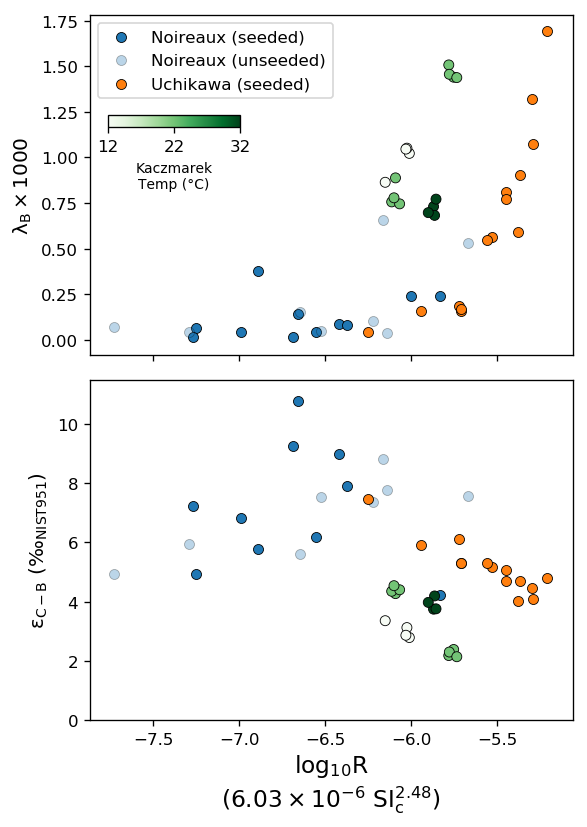

In [8]:
fig, axs = plt.subplots(2, 1, figsize=[5,7], sharex=True)

phase = 'Calcite'

cax, iax = axs

for exp in ['Noireaux', 'Uchikawa']:
    
    slc = idx[:, exp, phase]
    ind = rd.loc[slc, ('Solid', 'seeds')]
    
#     xo = rd.loc[slc, ('pitzer', 'SIc')]
#     x = np.log10(Rfn(xo, *p).astype(float))
    x = np.log10(rd.loc[slc, ('Solid', 'calc_R')].values)
    
    cax.scatter(x[ind],
                rd.loc[slc, ('Solid', 'LambdaB')][ind], label=exp + ' (seeded)',
                lw=0.5, edgecolor='k', c=cdict[exp])
    
    iax.scatter(x[ind],
                rd.loc[slc, ('Solid', 'EpsilonB')][ind], label=exp + ' (seeded)',
                lw=0.5, edgecolor='k', c=cdict[exp])
    
    if any(~ind):
        cax.scatter(x[~ind],
                rd.loc[slc, ('Solid', 'LambdaB')][~ind], label=exp + ' (unseeded)',
                lw=0.5, edgecolor='k', alpha=0.3, c=cdict[exp])
    
        iax.scatter(x[~ind],
                    rd.loc[slc, ('Solid', 'EpsilonB')][~ind], label=exp + ' (unseeded)',
                    lw=0.5, edgecolor='k', alpha=0.3, c=cdict[exp])
        
exp = 'Kaczmarek'
slc = idx[:, exp, phase]
xo = rd.loc[slc, ('pitzer', 'SIc')]
x = np.log10(Rfn(xo, *p).astype(float))
cm = cax.scatter(x.values,
                 rd.loc[slc, ('Solid', 'LambdaB')].values,
                 c=rd.loc[slc, ('Solution', 'Temp (°C)')], cmap=plt.cm.Greens,
                 lw=0.5, edgecolor='k')

iax.scatter(x,
            rd.loc[slc, ('Solid', 'EpsilonB')],
            c=rd.loc[slc, ('Solution', 'Temp (°C)')], cmap=plt.cm.Greens,
            lw=0.5, edgecolor='k')

cmx = fig.add_axes([.19,.84,.22,.015])
cb = plt.colorbar(cm, cax=cmx, label='Kaczmarek\nTemp (°C)', orientation='horizontal')
cb.set_ticks(rd.loc[slc, ('Solution', 'Temp (°C)')].unique())

cax.legend()
cax.set_ylabel('$\lambda_B \\times 1000$', fontsize=12)
iax.set_ylabel('$\epsilon_{C-B}\ (\u2030_{NIST951})$', fontsize=12)
# iax.axhline(0, ls='dashed', zorder=-1, c=(0,0,0,0.3))

iax.set_ylim(0,11.5)

iax.set_xlabel('$log_{10}R$\n$(6.03 \\times 10^{-6}\ SI_c^{2.48})$', fontsize=14)
fig.tight_layout()

# Data Fitting

In [9]:
# isolate seeded data only, remove Kaczmarek high-temperature point
rds = rd.loc[rd.loc[:, ('Solid', 'seeds')] &
             (rd.loc[:, ('Solution', 'Temp (°C)')] < 27) & 
             (rd.loc[:, ('Solid', 'EpsilonB')] > 0)]


In [10]:
fits = {}

In [11]:
# start fits from Uchikawa fit
initial_guess = np.load('fit_params.npy')

## Fit Noireaux Data

In [12]:
exp = 'Noireaux'

In [13]:
# prepare fitting variables
cind = idx[:, exp, :]

# Precipitation Rate
Rp = (rds.loc[cind, ('Solid', 'calc_R')]).values
logRp = np.log10(Rp)
# Solution BO3/C and BO4/CO3 ratios
rL3 = (rds.loc[cind, ('pitzer', 'BOH3')] / rds.loc[cind, ('pitzer', 'C')]).astype(float).values
rL4 = (rds.loc[cind, ('pitzer', 'BOH4_free')] / rds.loc[cind, ('pitzer', 'CO3')]).astype(float).values
# B/DIC for LambdaB calculation
B_DIC = (rds.loc[cind, ('pitzer', 'B')] / rds.loc[cind, ('pitzer', 'C')]).astype(float).values
# Isotopic content of each B species
ABO3 = d11_2_A11(rds.loc[cind, ('Solution', 'd11BO3 (permil vs NIST951)')].astype(float).values)
ABO4 = d11_2_A11(rds.loc[cind, ('Solution', 'd11BO4 (permil vs NIST951)')].astype(float).values)
# Borate d11B for EpsilonB calculation
dBO4 = rds.loc[cind, ('Solution', 'd11BO4 (permil vs NIST951)')].astype(float).values

# Measured LambdaB and EpsilonB fo residual calculation
LambdaB = rds.loc[cind, ('Solid', 'LambdaB')].astype(float).values
EpsilonB = rds.loc[cind, ('Solid', 'EpsilonB')].astype(float).values

# bias factor applied to lambda residuals to account for difference in
# the variance of the two parameters
lambda_bias = np.ptp(EpsilonB) / np.ptp(LambdaB)

In [14]:
fit = opt.minimize(fitfn, x0=initial_guess,
                   method='Powell', options={'maxiter': 2000, 'disp': True},
                   args=(Rp, rL3, rL4, B_DIC, ABO3, ABO4, dBO4,
                         LambdaB, EpsilonB, 1, 1, lambda_bias))

fits[exp] = fit

Optimization terminated successfully.
         Current function value: 19.382344
         Iterations: 10
         Function evaluations: 597


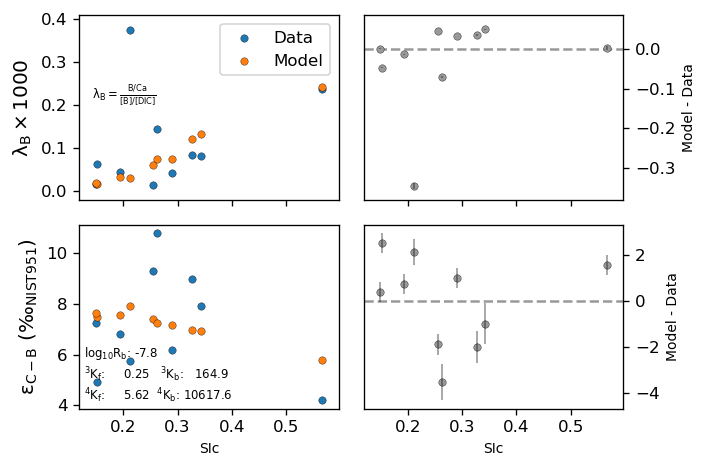

In [15]:
_ = model_vs_data(fit.x, rds, exp=exp, xvar=('pitzer', 'SIc'), Rvar=('Solid', 'calc_R'))

## Fit Kaczmarek Data

In [16]:
exp = 'Kaczmarek'

In [17]:
# prepare fitting variables
cind = idx[:, exp, :]

# Precipitation Rate
Rp = (rds.loc[cind, ('Solid', 'calc_R')]).values
logRp = np.log10(Rp)
# Solution BO3/C and BO4/CO3 ratios
rL3 = (rds.loc[cind, ('pitzer', 'BOH3')] / rds.loc[cind, ('pitzer', 'C')]).astype(float).values
rL4 = (rds.loc[cind, ('pitzer', 'BOH4_free')] / rds.loc[cind, ('pitzer', 'CO3')]).astype(float).values
# B/DIC for LambdaB calculation
B_DIC = (rds.loc[cind, ('pitzer', 'B')] / rds.loc[cind, ('pitzer', 'C')]).astype(float).values
# Isotopic content of each B species
ABO3 = d11_2_A11(rds.loc[cind, ('Solution', 'd11BO3 (permil vs NIST951)')].astype(float).values)
ABO4 = d11_2_A11(rds.loc[cind, ('Solution', 'd11BO4 (permil vs NIST951)')].astype(float).values)
# Borate d11B for EpsilonB calculation
dBO4 = rds.loc[cind, ('Solution', 'd11BO4 (permil vs NIST951)')].astype(float).values

# Measured LambdaB and EpsilonB fo residual calculation
LambdaB = rds.loc[cind, ('Solid', 'LambdaB')].astype(float).values
EpsilonB = rds.loc[cind, ('Solid', 'EpsilonB')].astype(float).values

# bias factor applied to lambda residuals to account for difference in
# the variance of the two parameters
lambda_bias = np.ptp(EpsilonB) / np.ptp(LambdaB)

In [18]:
fit = opt.minimize(fitfn, x0=initial_guess,
                   method='Powell', options={'maxiter': 2000, 'disp': True},
                   args=(Rp, rL3, rL4, B_DIC, ABO3, ABO4, dBO4,
                         LambdaB, EpsilonB, 1, 1, lambda_bias))

fits[exp] = fit

Optimization terminated successfully.
         Current function value: 0.569201
         Iterations: 8
         Function evaluations: 493


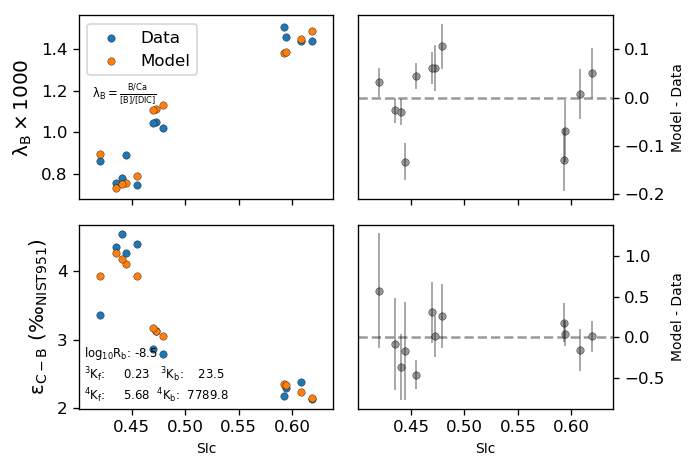

In [19]:
_ = model_vs_data(fit.x, rds, exp=exp, xvar=('pitzer', 'SIc'), Rvar=('Solid', 'calc_R'))

## Import Uchikawa Fit Parameters

In [20]:
fits['Uchikawa'] = {'x': np.load('fit_params.npy')}

## Plot Results

/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


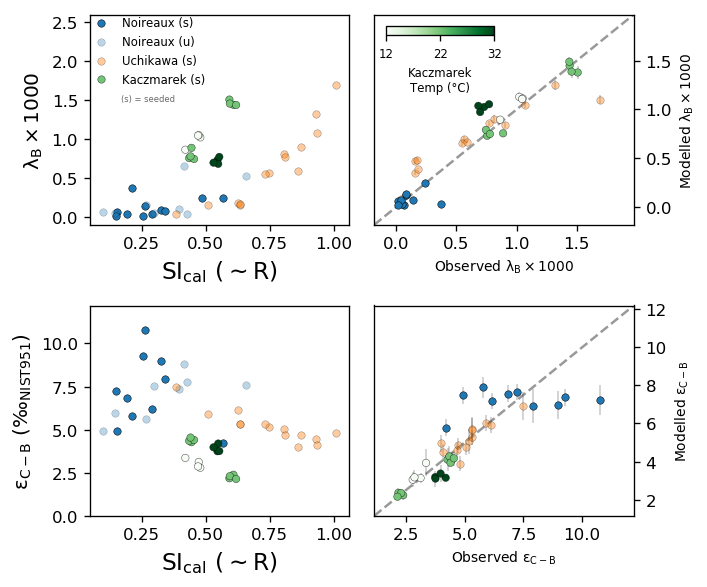

In [21]:
fig, axs = plt.subplots(2, 2, figsize=[6, 5])

phase = 'Calcite'

uni_opts = {'lw': 0.3,
            'edgecolor': (0,0,0,0.7),
            's': 20}
adict = {'Noireaux': 1,
         'Uchikawa': 0.4}

(cax, rcax), (iax, riax) = axs

for exp in ['Noireaux', 'Uchikawa']:
    slc = idx[:, exp, phase]
    ind = rd.loc[slc, ('Solid', 'seeds')]
    x = rd.loc[slc, ('pitzer', 'SIc')]
    cax.scatter(x[ind],
                rd.loc[slc, ('Solid', 'LambdaB')][ind], label=exp + ' (s)',
                c=cdict[exp], alpha=adict[exp], **uni_opts)
    
    iax.scatter(x[ind],
                rd.loc[slc, ('Solid', 'EpsilonB')][ind], label=exp + ' (s)',
                c=cdict[exp], alpha=adict[exp], **uni_opts)
    
    if any(~ind):
        cax.scatter(x[~ind],
                    rd.loc[slc, ('Solid', 'LambdaB')][~ind], label=exp + ' (u)',
                    alpha=0.3, c=cdict[exp], **uni_opts)
    
        iax.scatter(x[~ind],
                    rd.loc[slc, ('Solid', 'EpsilonB')][~ind], label=exp + ' (u)',
                    alpha=0.3, c=cdict[exp], **uni_opts)
        
exp = 'Kaczmarek'
slc = idx[:, exp, phase]
cm = cax.scatter(rd.loc[slc, ('pitzer', 'SIc')].values,
                 rd.loc[slc, ('Solid', 'LambdaB')].values,
                 c=rd.loc[slc, ('Solution', 'Temp (°C)')], cmap=plt.cm.Greens,
                 **uni_opts)

# for legend
cax.scatter(None, None, c=plt.cm.Greens(0.5), label=exp + ' (s)', **uni_opts)

iax.scatter(rd.loc[slc, ('pitzer', 'SIc')],
            rd.loc[slc, ('Solid', 'EpsilonB')],
            c=rd.loc[slc, ('Solution', 'Temp (°C)')], cmap=plt.cm.Greens,
            **uni_opts)

# draw residuals
exp = 'Uchikawa'
slc = idx[:, exp, phase]
(logRp, Rp, rL3, rL4, B_DIC, ABO3, ABO4, dBO4, LambdaB, EpsilonB, 
 LambdaB_err, EpsilonB_err, LambdaB_err_norm, EpsilonB_err_norm) = extract_model_vars(rds, exp, phase=phase)

LambdaB_pred, EpsilonB_pred = predfn(*fits[exp]['x'], Rp, rL3, rL4, B_DIC, ABO3, ABO4, dBO4)

rx = rds.loc[slc, ('pitzer', 'SIc')]
rcax.scatter(LambdaB, LambdaB_pred, c=cdict[exp], alpha=adict[exp], **uni_opts)
rcax.errorbar(LambdaB,
              LambdaB_pred, 
              yerr=LambdaB_err,
              color=(0,0,0,0.2), lw=0, elinewidth=1, label='_', zorder=-1)


riax.scatter(EpsilonB, EpsilonB_pred, c=cdict[exp], alpha=adict[exp], **uni_opts)
riax.errorbar(EpsilonB,
              EpsilonB_pred, 
              yerr=EpsilonB_err,
              color=(0,0,0,0.2), lw=0, elinewidth=1, label='_', zorder=-1)

exp = 'Noireaux'
slc = idx[:, exp, phase]
(logRp, Rp, rL3, rL4, B_DIC, ABO3, ABO4, dBO4, LambdaB, EpsilonB, 
 LambdaB_err, EpsilonB_err, LambdaB_err_norm, EpsilonB_err_norm) = extract_model_vars(rds, exp, ('Solid', 'calc_R'), phase)

LambdaB_pred, EpsilonB_pred = predfn(*fits[exp]['x'], Rp, rL3, rL4, B_DIC, ABO3, ABO4, dBO4)

rcax.scatter(LambdaB, LambdaB_pred, c=cdict[exp], alpha=adict[exp], **uni_opts)
rcax.errorbar(LambdaB,
              LambdaB_pred, 
              yerr=LambdaB_err,
              color=(0,0,0,0.2), lw=0, elinewidth=1, label='_', zorder=-1)


riax.scatter(EpsilonB, EpsilonB_pred, c=cdict[exp], alpha=adict[exp], **uni_opts)
riax.errorbar(EpsilonB,
              EpsilonB_pred, 
              yerr=EpsilonB_err,
              color=(0,0,0,0.2), lw=0, elinewidth=1, label='_', zorder=-1)

exp = 'Kaczmarek'
slc = idx[:, exp, phase]
(logRp, Rp, rL3, rL4, B_DIC, ABO3, ABO4, dBO4, LambdaB, EpsilonB, 
 LambdaB_err, EpsilonB_err, LambdaB_err_norm, EpsilonB_err_norm) = extract_model_vars(rd, exp, ('Solid', 'calc_R'))

LambdaB_pred, EpsilonB_pred = predfn(*fits[exp]['x'], Rp, rL3, rL4, B_DIC, ABO3, ABO4, dBO4)

rx = rd.loc[slc, ('pitzer', 'SIc')]
c = rd.loc[slc, ('Solution', 'Temp (°C)')]
rcax.scatter(LambdaB, LambdaB_pred, c=c, cmap=plt.cm.Greens, **uni_opts)
rcax.errorbar(LambdaB,
              LambdaB_pred, 
              yerr=LambdaB_err,
              color=(0,0,0,0.2), lw=0, elinewidth=1, label='_', zorder=-1)


riax.scatter(EpsilonB, EpsilonB_pred, c=c, cmap=plt.cm.Greens, **uni_opts)
riax.errorbar(EpsilonB,
              EpsilonB_pred, 
              yerr=EpsilonB_err,
              color=(0,0,0,0.2), lw=0, elinewidth=1, label='_', zorder=-1)



# labels and legends

cax.legend(loc=(-0.02, .64), fontsize=7, framealpha=0)
cax.set_ylim(-0.1, 2.6)
iax.set_ylim(0, 12.2)
cax.text(0.12, 0.62, '(s) = seeded', va='top', ha='left', transform=cax.transAxes, color=(0,0,0,0.6), fontsize=5)

cmx = fig.add_axes([.545, .93, .15, .015])
cb = plt.colorbar(cm, cax=cmx, orientation='horizontal')
cb.set_label('Kaczmarek\nTemp (°C)', fontsize=7)
cb.set_ticks(rd.loc[slc, ('Solution', 'Temp (°C)')].unique())
cb.ax.tick_params(labelsize=7)

for rx in [rcax, riax]:
    lims = np.concatenate([rx.get_xlim(), rx.get_ylim()])
    rxlim = [lims.min() - 0.05 * lims.ptp(), lims.max() + 0.1 * lims.ptp()]
    rx.set_xlim(rxlim)
    rx.set_ylim(rxlim)
    rx.plot(rxlim, rxlim, color=(0,0,0,0.4), ls='dashed', zorder=-1)
    rx.yaxis.tick_right()
    rx.yaxis.set_label_position('right')


# cax.legend()
cax.set_ylabel('$\lambda_B \\times 1000$', fontsize=12)
iax.set_ylabel('$\epsilon_{C-B}\ (\u2030_{NIST951})$', fontsize=12)

iax.set_xlabel('$SI_{cal}\ (\sim R)$', fontsize=14)
cax.set_xlabel('$SI_{cal}\ (\sim R)$', fontsize=14)

rcax.set_xlabel('Observed $\lambda_B \\times 1000$')
rcax.set_ylabel('Modelled $\lambda_B \\times 1000$')

riax.set_xlabel('Observed $\epsilon_{C-B}$')
riax.set_ylabel('Modelled $\epsilon_{C-B}$')

fig.tight_layout()

fig.savefig('../../Figures/Fig6-SI-plot.pdf')

In [22]:
par = ['Kb3', 'Kf3', 'Kb4', 'Kf4', 'logRb']
params = pd.DataFrame(columns=par, index=['Uchikawa', 'Noireaux', 'Kaczmarek'])

for k, v in fits.items():
    params.loc[k, par] = v['x']

In [23]:
params

,Kb3,Kf3,Kb4,Kf4,logRb
Uchikawa,319.299,0.482526,7398.97,5.47955,-7.78278
Noireaux,164.942,0.250601,10617.6,5.62211,-7.81971
Kaczmarek,23.4944,0.230483,7789.83,5.678,-8.51673
